<h1 style="font-family:Impact,Arial;font-size:30px;">37005 Fundamental of Derivative Security Pricing - Spring 2024</h1>
<h1 style="font-family:Impact,Arial;font-size:20px;">Group Assignment Part 1</h1>
<p style="font-family:Arial;">Group 1</p>
<ul>
<li>Hayoung Lee</li>
<li>Quoc Thai Tran</li>
<li>Alexis Cullet</li>
<li>Ziqi Zhou</li>
</ul>


# Import package


In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize, fsolve
from scipy.stats import norm
import matplotlib.pyplot as plt

# Import data


In [2]:
def data_preprocessing():
    df = pd.read_excel('spx_quotedata20220308_all.xlsx')
    df.drop(columns=['Last Sale', 'Calls', 'Net', 'IV', 'Delta', 'Gamma', 'Open Interest', 'Puts', 'Last Sale.1', 'Net.1', 'IV.1', 'Delta.1', 'Gamma.1', 'Open Interest.1'], inplace=True)
    df.rename(columns={'Bid': 'Call Bid', 'Ask': 'Call Ask', 'Volume': 'Call Volume', 'Bid.1':'Put Bid', 'Ask.1':'Put Ask', 'Volume.1':'Put Volume'}, inplace=True)
    df['Expiration Date']=pd.to_datetime(df['Expiration Date'], format='%a %b %d %Y')
    df['Call Price']=(df['Call Bid']+df['Call Ask'])/2
    df['Put Price']=(df['Put Bid']+df['Put Ask'])/2
    df.sort_values(by=['Expiration Date', 'Strike'], ascending=True, inplace=True)
    df.reset_index(drop=True, inplace=True)
    columns = df.columns.tolist()
    return df[columns[:2]+['Call Price']+columns[2:6]+['Put Price']+columns[6:-2]]
data_preprocessing()

,Expiration Date,Call Bid,Call Price,Call Ask,Call Volume,Strike,Put Bid,Put Price,Put Ask,Put Volume
0,2022-03-09,1151.7,1160.30,1168.9,0,3000,0.0,0.025,0.05,6
1,2022-03-09,951.7,960.40,969.1,0,3200,0.0,0.025,0.05,4
2,2022-03-09,851.2,860.25,869.3,0,3300,0.0,0.025,0.05,2182
3,2022-03-09,751.7,760.40,769.1,0,3400,0.0,0.025,0.05,360
4,2022-03-09,651.2,660.30,669.4,0,3500,0.0,0.025,0.05,1264
...,...,...,...,...,...,...,...,...,...,...
5886,2026-12-18,34.3,74.30,114.3,0,7200,2602.4,2698.400,2794.40,80
5887,2026-12-18,0.0,150.00,300.0,0,8000,3299.5,3395.500,3491.50,3
5888,2026-12-18,0.0,150.00,300.0,0,8600,3832.4,3928.400,4024.40,5
5889,2026-12-18,0.0,150.00,300.0,0,9000,4190.1,4286.100,4382.10,2


# Task 1

Task 1 result
     Maturity  Dividend Discount Factor  Zero Coupon Bond
0  2022-03-09                  0.997496          0.999965
1  2022-03-11                  0.997462          1.000079
2  2022-03-14                  0.997263          1.000150
3  2022-03-16                  0.997030          0.999847
4  2022-03-18                  0.996945          0.999927
5  2022-03-21                  0.997252          1.000222
6  2022-03-23                  0.997327          1.000346
7  2022-03-25                  0.996831          0.999867
8  2022-03-28                  0.996913          0.999969
9  2022-03-30                  0.996952          1.000063
10 2022-03-31                  0.996890          1.000010
11 2022-04-01                  0.996910          1.000076
12 2022-04-04                  0.996823          0.999953
13 2022-04-06                  0.997161          1.000491
14 2022-04-08                  0.996610          1.000066
15 2022-04-14                  0.996567          1.000017


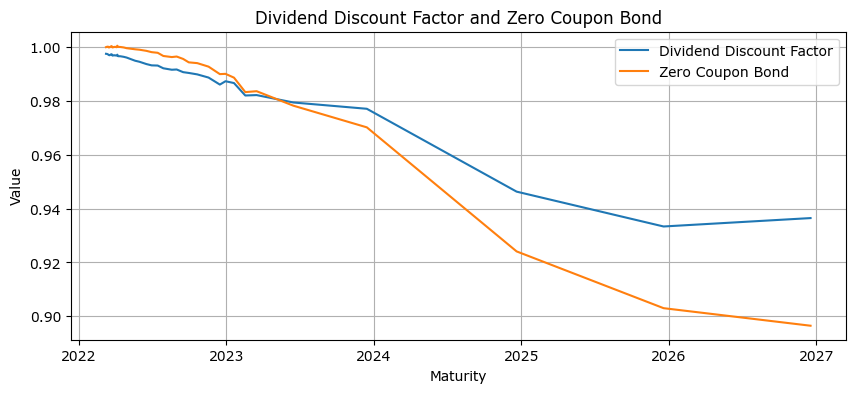

In [3]:
def task_1(stock):
    df = data_preprocessing()
    maturity = list(set(df['Expiration Date']))
    dividend = []
    discount_factor = []
    for date in maturity:
        data = df[df['Expiration Date']==date]
        strike = data['Strike'].to_numpy()
        call = data['Call Price'].to_numpy()
        put = data['Put Price'].to_numpy()
        def target_minimizer(x):
            calc = x[0]*stock-x[1]*strike-(call-put)
            return np.sum(np.power(calc-np.mean(calc),2))
        result = minimize(target_minimizer, np.ones(2), constraints={
            'type':'eq',
            'fun':lambda x: np.sum(x[0]*stock-x[1]*strike-(call-put))
        }).x
        dividend.append(result[0])
        discount_factor.append(result[1])
    information = pd.DataFrame({'Maturity':pd.to_datetime(maturity), 'Dividend Discount Factor':dividend, 'Zero Coupon Bond':discount_factor})
    information.sort_values(by=['Maturity'], ascending=True, inplace=True)
    information.reset_index(drop=True, inplace=True)
    return information
task_1_df = task_1(4170.7002)
print("Task 1 result")
print(task_1_df)
plt.figure(figsize=(10,4))
plt.plot(task_1_df['Maturity'], task_1_df['Dividend Discount Factor'], label='Dividend Discount Factor')
plt.plot(task_1_df['Maturity'], task_1_df['Zero Coupon Bond'], label='Zero Coupon Bond')
plt.xlabel('Maturity')
plt.ylabel('Value')
plt.grid()
plt.title('Dividend Discount Factor and Zero Coupon Bond')
plt.legend()
plt.show()

# Task 2

$dS(T) = S(t) (\mu dt+\sigma dW(t)) $

$=S(t) ((r(t) - q(t))dt + \sigma (t) dW(t)) $

Applying Itô's lemma :

$\ln(S(T)) = \ln(S(0)) + \int_{0}^{T} r(t)dt - \int_{0}^{T} q(t)dt -\frac{1}{2} \int_{0}^{T} \sigma^{2}(t)dt + \int_{0}^{T} \sigma(t) dW(t) $

Therefore

$\ln(S(T)) = \ln(S(0)) - \ln (B(0,T)) + \ln(D(0,T)) -\frac{1}{2} \sum_{i=1}^{N} \int_{T_{i-1}}^{T_i} \sigma_i^2 dt + \sum_{i=1}^{N} \int_{T_{i-1}}^{T_i} \sigma_i dW(t) $

So we have

$\ln(S(0)\frac{D(0,T)}{B(0,T)}) -\frac{1}{2} \sum_{i=1}^{N} \sigma_i^2(T_i - T_{i-1}) + \sum_{i=1}^{N} \sigma_i(W(T_i) - W(T_{i-1}))  $



$\implies \ln(S(T)) \sim \mathcal{N} (\ln(S(0)\frac{D(0,T)}{B(0,T)})-\frac{1}{2} \sum_{i=1}^{N} \sigma_i^2(T_i - T_{i-1})  ,  \sum_{i=1}^{N} \sigma_i^2(T_i - T_{i-1})) $

Which yields the following classical Black-Scholes formula :

$$
C(0)=S(0)D(0,T_i)\phi(d_1)-KB(0,T_i)\phi(d_2)
$$

with


$$
d_{1,2}=\frac{\ln(\frac{S(0)}{K})-\ln(\frac{B(0,T_i)}{D(0,T_i)})\pm\frac{1}{2}\sum_{i=1}^{n}\sigma _i^2(T_i-T_{i-1})}{\sqrt{\sum_{i=1}^{n}\sigma _i^2(T_i-T_{i-1})}}
$$

Task 2 result
     Maturity  Bid Implied Volatility  Ask Implied Volatility
0  2022-03-09                0.341898                0.413275
1  2022-03-11                0.336409                0.351895
2  2022-03-14                0.275448                0.236758
3  2022-03-16                0.398176                0.400603
4  2022-03-18                0.287762                0.382516
5  2022-03-21                0.277681                0.192261
6  2022-03-23                0.331576                0.331044
7  2022-03-25                0.322377                0.326044
8  2022-03-28                0.196921                0.200403
9  2022-03-30                0.315007                0.316442
10 2022-03-31                0.346907                0.348431
11 2022-04-01                0.350036                0.346541
12 2022-04-04                0.187724                0.191559
13 2022-04-06                0.307043                0.311270
14 2022-04-08                0.325269                0.3

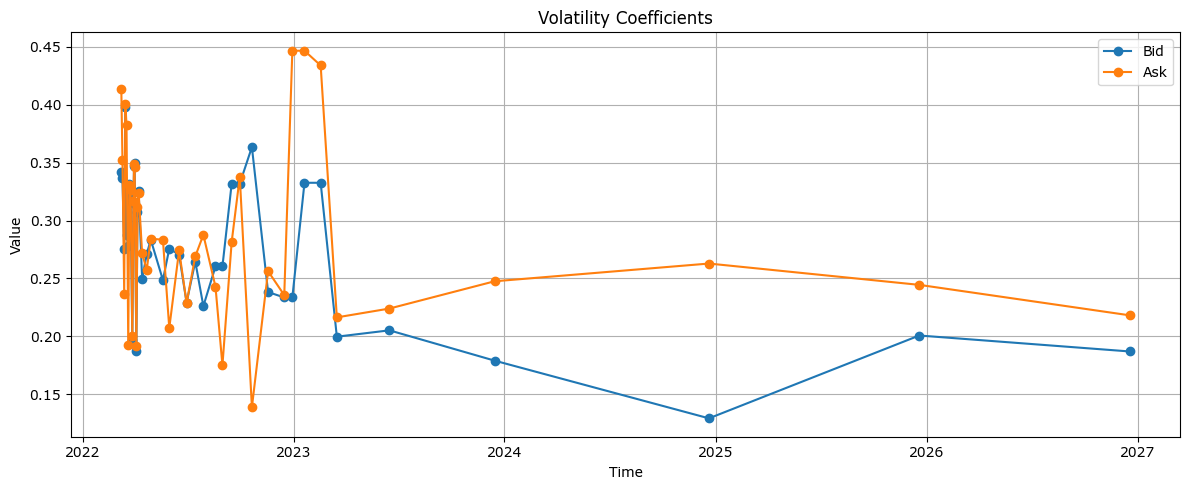

In [7]:
def task_2(stock, noti=None):
    data = data_preprocessing()
    dfs = task_1(stock)
    today = pd.to_datetime('2022-03-08')
    vola = [[],[]]
    sigma = [[],[]]
    for i in range(len(dfs)):
        ext_data = data[data['Expiration Date']==dfs.iloc[i,0]].reset_index(drop=True)
        ext_data['diff']=np.abs(ext_data['Strike']-stock*dfs.iloc[i,1]/dfs.iloc[i,2])
        chosen_data = list(ext_data.loc[ext_data['diff'].idxmin()])[:-1]
        isCall = True if chosen_data[3]-chosen_data[1]>chosen_data[8]-chosen_data[6] else False
        def solver(x, type):
            d1 = (np.log(stock/chosen_data[5])-np.log(dfs.iloc[i,2]/dfs.iloc[i,1])+0.5 * x)/(np.sqrt(x))
            d2 = d1-np.sqrt(x)
            if isCall:
                return stock*dfs.iloc[i,1]*norm.cdf(d1)-chosen_data[5]*dfs.iloc[i,2]*norm.cdf(d2) - chosen_data[1 if type=='bid' else 3]
            else:
                return chosen_data[5]*dfs.iloc[i,2]*norm.cdf(-d2)-stock*dfs.iloc[i,1]*norm.cdf(-d1) - chosen_data[6 if type=='bid' else 8]
        vola[0].append(fsolve(solver, 0.001, args=('bid'))[0])
        vola[1].append(fsolve(solver, 0.001, args=('ask'))[0])
    sum_vola=pd.DataFrame({'Maturity':dfs['Maturity'], 'Bid Implied Volatility':vola[0], 'Ask Implied Volatility':vola[1]})
    vola[0]=np.concatenate(([vola[0][0]],np.diff(vola[0])))
    vola[1]=np.concatenate(([vola[1][0]],np.diff(vola[1])))
    for i in range(len(dfs)):
        delta_t = (dfs.iloc[i,0]-today).days/((today+pd.DateOffset(years=1))-today).days if i==0 else (dfs.iloc[i,0]-dfs.iloc[i-1,0]).days/((dfs.iloc[i-1,0]+pd.DateOffset(years=1))-dfs.iloc[i-1,0]).days
        for j in range(2):
            if vola[j][i]<0:
                if noti is not None:
                    print('Negative Volatility Detected: Maturity:', dfs.iloc[i,0], 'Type:', 'Bid' if j==0 else 'Ask','. Set to previous value: ', sigma[j][-1])
                sigma[j].append(sigma[j][-1])
            else:
                sigma[j].append(np.sqrt(vola[j][i]/delta_t))
    return pd.DataFrame({'Maturity':dfs['Maturity'], 'Bid Implied Volatility':sigma[0], 'Ask Implied Volatility':sigma[1]}), sum_vola
task_2_df, _ = task_2(4170.7002)
print("Task 2 result")
print(task_2_df)
plt.figure(figsize=(12, 5))
plt.plot(task_2_df['Maturity'], task_2_df['Bid Implied Volatility'], label='Bid', marker='o')
plt.plot(task_2_df['Maturity'], task_2_df['Ask Implied Volatility'], label='Ask', marker='o')
plt.title('Volatility Coefficients')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Task 4

before # "Fair" guarantee level g --> Value of the contract calculated by volatility with bid price = Value of the contract calculated by volatility with ask price  

now # "Fair" guarantee level g --> S(0) = value of the contract using implied ask volatility

It means that the option's price matches the client's investment

ith sum_vol : $\sigma_i^2 (T_i - T_{i-1})$

sum of implied ask volatility : $\sum_{i=1}^{n}\sigma_i^2 (T_i - T_{i-1})$

In [11]:
def guarantee(stock, alpha, initial_value, sum_vola):
    dfs = task_1(stock)
    today = pd.to_datetime('2022-03-08')
    maturity = pd.to_datetime('2026-12-18')
    sum_vol2_ask = sum(sum_vola['Ask Implied Volatility'])
    def solver(g):
        D_0T = dfs[dfs['Maturity']==maturity].iloc[0,1] 
        B_0T = dfs[dfs['Maturity']==maturity].iloc[0,2] 
        TimeToMat = (maturity-today).days/((today+pd.DateOffset(years=1))-today).days

        h1_ask = (np.log( stock/np.exp(g * TimeToMat / (1-alpha))) - np.log(stock * D_0T/B_0T) + 1/2 * sum_vol2_ask ) / np.sqrt(sum_vol2_ask)
        h2_ask = ( - np.log( stock/np.exp(g * TimeToMat / (1-alpha))) + np.log(stock * D_0T/B_0T) + (1/2-alpha) * sum_vol2_ask ) / np.sqrt(sum_vol2_ask)

        Val_ask = B_0T * (stock * np.exp(g * TimeToMat) * norm.cdf(h1_ask) + stock * np.power(D_0T/B_0T, (1-alpha)) * np.exp( (alpha**2 - alpha)/2 *sum_vol2_ask) ) * norm.cdf(h2_ask)

        eqs = stock - Val_ask
        return eqs
    return fsolve(solver, initial_value)[0]
_, sum_vola = task_2(4170.7002)
print("alpha : ",0.25,"guarantee g : ",guarantee(4170.7002, 0.25, 0, sum_vola))
print("alpha : ",0.5,"guarantee g : ",guarantee(4170.7002, 0.5, 0, sum_vola))
print("alpha : ",0.75,"guarantee g : ",guarantee(4170.7002, 0.75, 0, sum_vola))

alpha :  0.25 guarantee g :  0.019758860458996455
alpha :  0.5 guarantee g :  0.06863825969674771
alpha :  0.75 guarantee g :  0.08828127453062391


C:\Users\1tran\AppData\Local\Temp\ipykernel_4156\1353779993.py:18: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  return fsolve(solver, initial_value)[0]
